Veri yükleme testi başlıyor...
--------------------------------------------------
Veri yolu: d:\ecg\data\raw\ptbxl
Yüklenen kayıt: 0/10

Yüklenen toplam kayıt: 10

Veri şekli:
X shape: (10, 5000, 12)
y shape: (10, 5)


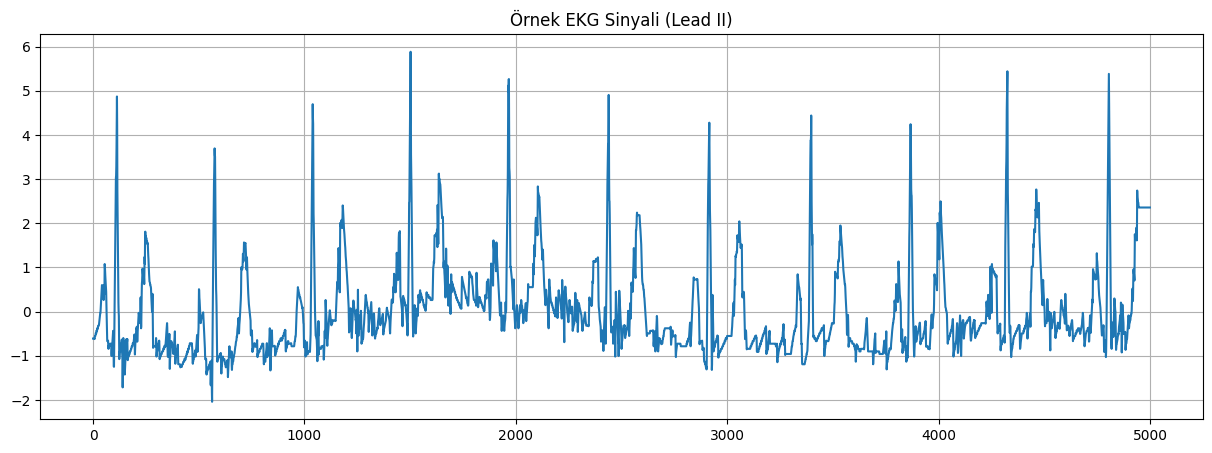

In [1]:
# notebooks/06_model_training.ipynb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import wfdb
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class PTBXLDataset(Dataset):
    def __init__(self, waveforms, labels):
        self.waveforms = torch.FloatTensor(waveforms).transpose(1, 2)  # (N, time, leads) -> (N, leads, time)
        self.labels = torch.FloatTensor(labels)
        
    def __len__(self):
        return len(self.waveforms)
    
    def __getitem__(self, idx):
        return self.waveforms[idx], self.labels[idx]

def prepare_ptbxl_data(data_path, n_samples=1000):
    """PTB-XL verisini hazırla"""
    print(f"Veri yolu: {data_path}")
    
    # Meta verileri yükle
    df = pd.read_csv(data_path / "ptbxl_database.csv")
    df.scp_codes = df.scp_codes.apply(eval)  # String'den dict'e çevir
    
    if n_samples:
        df = df.head(n_samples)
    
    # Tanı sınıfları
    diagnostic_classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
    
    # Veri yükleme
    waveforms = []
    labels = np.zeros((len(df), len(diagnostic_classes)))
    
    for idx, row in df.iterrows():
        if idx % 100 == 0:
            print(f"Yüklenen kayıt: {idx}/{len(df)}")
            
        # EKG sinyalini yükle
        record_path = data_path / row['filename_hr'].replace('.hea', '')
        try:
            record = wfdb.rdrecord(str(record_path))
            waveform = record.p_signal
            
            # Normalize et
            scaler = StandardScaler()
            waveform = scaler.fit_transform(waveform)
            waveforms.append(waveform)
            
            # Etiketleri hazırla
            for diagnosis in row.scp_codes:
                if diagnosis in diagnostic_classes:
                    labels[idx, diagnostic_classes.index(diagnosis)] = 1
                    
        except Exception as e:
            print(f"Hata - Kayıt {idx}: {str(e)}")
            print(f"Dosya yolu: {record_path}")
            continue
    
    print(f"\nYüklenen toplam kayıt: {len(waveforms)}")
    return np.array(waveforms), labels

# Veri yükleme testi
data_path = Path("d:/ecg/data/raw/ptbxl")
print("Veri yükleme testi başlıyor...")
print("-" * 50)

try:
    # Önce az sayıda veri ile test et
    X, y = prepare_ptbxl_data(data_path, n_samples=10)
    print("\nVeri şekli:")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    # Örnek bir EKG'yi görselleştir
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(15, 5))
    plt.plot(X[0, :, 1])  # İlk kayıt, Lead II
    plt.title('Örnek EKG Sinyali (Lead II)')
    plt.grid(True)
    plt.show()
    
except Exception as e:
    print(f"Hata: {str(e)}")

In [2]:
def prepare_ptbxl_data(data_path, n_samples=1000):
    """PTB-XL verisini hazırla"""
    print(f"Veri yolu: {data_path}")
    
    # Meta verileri yükle
    df = pd.read_csv(data_path / "ptbxl_database.csv")
    df.scp_codes = df.scp_codes.apply(eval)  # String'den dict'e çevir
    
    if n_samples:
        df = df.head(n_samples)
    
    # Tanı sınıfları
    diagnostic_classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
    
    # Veri yükleme
    valid_records = []
    valid_labels = []
    
    for idx, row in df.iterrows():
        if idx % 100 == 0:
            print(f"İşlenen kayıt: {idx}/{len(df)}")
            
        # EKG sinyalini yükle
        record_path = data_path / row['filename_hr'].replace('.hea', '')
        try:
            record = wfdb.rdrecord(str(record_path))
            waveform = record.p_signal
            
            # Normalize et
            scaler = StandardScaler()
            waveform = scaler.fit_transform(waveform)
            
            # Etiket hazırla
            label = np.zeros(len(diagnostic_classes))
            for diagnosis in row.scp_codes:
                if diagnosis in diagnostic_classes:
                    label[diagnostic_classes.index(diagnosis)] = 1
            
            # Geçerli kayıtları sakla
            valid_records.append(waveform)
            valid_labels.append(label)
            
        except Exception as e:
            continue  # Hatalı kayıtları atla
    
    X = np.array(valid_records)
    y = np.array(valid_labels)
    
    print(f"\nToplam geçerli kayıt: {len(X)}")
    print(f"Veri boyutları: X={X.shape}, y={y.shape}")
    
    # Sınıf dağılımını göster
    print("\nSınıf dağılımı:")
    for i, cls in enumerate(diagnostic_classes):
        count = y[:, i].sum()
        print(f"{cls}: {count:.0f} kayıt ({count/len(y)*100:.1f}%)")
    
    return X, y

# Test edelim
print("Veri yükleme başlıyor...")
X, y = prepare_ptbxl_data(data_path, n_samples=1000)

# Veri setini böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DataLoader'ları oluştur
train_dataset = PTBXLDataset(X_train, y_train)
test_dataset = PTBXLDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print("\nVeri yükleme tamamlandı!")

Veri yükleme başlıyor...
Veri yolu: d:\ecg\data\raw\ptbxl
İşlenen kayıt: 0/1000
İşlenen kayıt: 100/1000
İşlenen kayıt: 200/1000
İşlenen kayıt: 300/1000
İşlenen kayıt: 400/1000
İşlenen kayıt: 500/1000
İşlenen kayıt: 600/1000
İşlenen kayıt: 700/1000
İşlenen kayıt: 800/1000
İşlenen kayıt: 900/1000

Toplam geçerli kayıt: 988
Veri boyutları: X=(988, 5000, 12), y=(988, 5)

Sınıf dağılımı:
NORM: 529 kayıt (53.5%)
MI: 0 kayıt (0.0%)
STTC: 0 kayıt (0.0%)
CD: 0 kayıt (0.0%)
HYP: 0 kayıt (0.0%)

Veri yükleme tamamlandı!


In [3]:
# Model eğitimi için son hazırlıklar
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılan cihaz: {device}")

# Model oluştur
model = ECGClassifier().to(device)

# Eğitim parametreleri
n_epochs = 30
batch_size = 32
learning_rate = 0.001

# Optimizer ve loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

print("\nEğitim başlıyor...")
print(f"Toplam epoch: {n_epochs}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print("-" * 50)

# Eğitim
history = train_model(model, train_loader, test_loader, n_epochs=n_epochs)

# Eğitim sonuçlarını görselleştir
plt.figure(figsize=(15, 5))

# Loss grafiği
plt.subplot(121)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# En iyi modeli test et
print("\nEn iyi model test ediliyor...")
checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Test seti üzerinde performans
test_preds = []
test_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = torch.sigmoid(output)
        
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(target.cpu().numpy())

test_preds = np.array(test_preds)
test_targets = np.array(test_targets)

# Her sınıf için metrikler
print("\nTest Seti Sonuçları:")
print("-" * 50)
for i, cls in enumerate(diagnostic_classes):
    pred_i = (test_preds[:, i] > 0.5).astype(int)
    target_i = test_targets[:, i]
    
    accuracy = (pred_i == target_i).mean()
    precision = np.sum((pred_i == 1) & (target_i == 1)) / (np.sum(pred_i == 1) + 1e-10)
    recall = np.sum((pred_i == 1) & (target_i == 1)) / (np.sum(target_i == 1) + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    
    print(f"\n{cls}:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1:.3f}")

# Modeli kaydet
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'diagnostic_classes': diagnostic_classes,
    'history': history,
}, 'ecg_model_final.pt')

print("\nEğitim tamamlandı ve model kaydedildi!")

Kullanılan cihaz: cpu


NameError: name 'ECGClassifier' is not defined